### Compare CONUS2 and USGS streamflow ###
DTT, 10/22

This notebook reads in CSVs of CONUS2 daily mean flow [cms] and daily mean USGS flow [cms] and creates comparison hydrographs. Gages have been matched between the two csv's to make sure that we're comparing viable gage locations in `1_Organize_Streamflow.ipynb`. 

Inputs:
- CONUS2 daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb`
- USGS daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb` 
- USGS gage metadata csv, ouput from `1_Organize_Streamflow.ipynb` 

Outputs:
- Hydrographs of USGS and CONUS2 flow

Notes:
- as of 11/22 there are no stats included in these hydrographs. Need to either add a calculation here or pull from the SaveStreamflowStats.ipynb and add these to the plots

In [1]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import geopandas as gpd

In [2]:
water_year = 2003
# Directory containing output csv's from `Make_CONUS2_streamflow_csv.py`
#organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
organized_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'


# Where you want to save plots, etc. to
#plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow'
print(f'Figures saving to: {plot_dir}')


# names of csv files
usgs_csv = 'USGS_Daily_matched_flow_cms_2003.csv'
pf_csv = 'PFCONUS2_Daily_matched_flow_cms_2003.csv'
metadata_csv = 'USGS_metadata_matched_flow_2003.csv'
stats_csv = 'Summary_Gages_CONUS2_WY2003.csv'

Figures saving to: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Streamflow


### Read in files
Read in PF flow, USGS flow, USGS metadata, and calculated stats from `SaveStreamflowStats.ipynb`

In [3]:
### read in CONUS2 daily flow matched csv
pfdata = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
#pf_flow_matched = pfdata.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
pfdata.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1010000,43.948426,40.765870,34.389042,27.512755,22.526485,18.593126,15.312236,12.532960,10.260977,8.550327,...,0.228571,0.168567,0.238709,0.472419,0.646194,0.612115,0.546623,0.822631,8.067395,0.0
1010070,5.335298,3.581117,2.112628,1.401444,1.006803,0.803474,0.716559,0.526913,0.385837,0.335107,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116555,2.476887,0.0
1010500,94.018137,87.844915,81.101017,74.425605,67.642209,60.635444,52.793281,44.862003,38.017604,32.625893,...,1.563807,1.286330,1.151007,1.301772,1.288099,1.414516,1.376162,1.649360,44.722650,0.0
1011000,37.266464,34.151593,31.949418,28.746042,24.794453,21.037749,17.725660,14.927488,12.823219,11.328315,...,0.383030,0.248542,0.270354,0.370566,0.447849,0.437744,0.346303,1.857882,32.173826,0.0
1013500,18.686342,17.994405,17.171830,14.470901,14.358695,12.452931,11.061765,10.040905,9.119768,8.499280,...,0.542694,0.269608,0.231789,0.451696,0.321280,0.249696,0.204132,1.203276,30.743592,0.0


In [4]:
### read in USGS daily flow matched csv
usgsdata = pd.read_csv(f'{organized_dir}/{usgs_csv}',index_col=['site_id']) 
usgsdata.head()
# # change zero values in USGS df so that we can calculate stats without errors
# usgsdata = usgsdata.where(usgsdata>0, 0.0001)

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1010000,9.16920,7.83910,7.72590,6.79200,5.77320,5.12230,4.72610,4.47140,4.13180,3.93370,...,4.07520,3.99030,3.99030,4.38650,6.39580,7.07500,6.84860,7.47120,8.97110,9.19750
1010070,0.59713,0.50657,0.45846,0.43582,0.42733,0.39054,0.37922,0.36224,0.37073,0.39903,...,0.94805,0.89994,0.90277,1.03578,1.35274,1.42066,1.39236,1.33576,1.64423,1.52254
1010500,8.32020,11.46150,12.93310,11.37660,11.40490,10.30120,9.28240,8.20700,7.52780,7.44290,...,11.60300,11.40490,11.12190,11.91430,13.15950,13.95190,15.90460,18.05540,58.58100,74.14600
1011000,7.41460,7.38630,6.99010,6.56560,6.36750,6.19770,5.74490,5.06570,4.52800,4.41480,...,12.65010,12.36710,11.94260,12.70670,13.69720,13.61230,13.15950,14.00850,66.22200,76.12700
1013500,3.50920,3.42430,3.16960,3.11300,3.33940,2.85830,2.85830,2.63190,2.40550,2.50455,...,14.37640,13.81040,13.61230,13.55570,13.15950,12.25390,11.94260,15.76310,58.29800,51.22300


In [5]:
### read in USGS streamflow gage metadata for all gages with flow in October
usgs_gage_metadata = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])#, 
#usgs_gage_metadata = usgs_gage_metadata.drop(columns=['Unnamed: 0'])
#usgs_all_gages = usgs_all_gages.transpose() #transpose df for easier plotting
usgs_gage_metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,local_time_fg,reliability_cd,project_no,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1010000,stream gauge,USGS,"St. John River at Ninemile Bridge, Maine",1010000,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,46.700556,-69.715556,ME,1010001,...,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1341.0,1341.0,Y,NaN,442300100,365
1010070,stream gauge,USGS,"Big Black River near Depot Mtn, Maine",1010070,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,46.893889,-69.751667,ME,1010001,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,171.0,171.0,Y,NaN,442300100,365
1010500,stream gauge,USGS,"St. John River at Dickey, Maine",1010500,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,47.113056,-69.088056,ME,1010001,...,NaN,YNNNYNNNNYNNNYNNYNNNNNNNNNNNNN,NaN,NaN,2680.0,2680.0,Y,NaN,442300100,365
1011000,stream gauge,USGS,"Allagash River near Allagash, Maine",1011000,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,47.069722,-69.079444,ME,1010002,...,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1478.0,1229.0,Y,NaN,442300100,365
1013500,stream gauge,USGS,"Fish River near Fort Kent, Maine",1013500,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,47.237500,-68.582778,ME,1010003,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,873.0,873.0,Y,NaN,442300100,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14366000,stream gauge,USGS,"APPLEGATE RIVER NEAR APPLEGATE, OR",14366000,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,42.241511,-123.140049,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,483.0,NaN,Y,C,NaN,365
14369500,stream gauge,USGS,"APPLEGATE RIVER NEAR WILDERVILLE, OR",14369500,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,42.354006,-123.406728,OR,17100309,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,698.0,NaN,Y,C,NaN,365
14372300,stream gauge,USGS,"ROGUE RIVER NEAR AGNESS, OR",14372300,https://waterservices.usgs.gov/nwis/site/?form...,2023-05-30,42.578442,-124.058144,OR,17100310,...,NaN,NNNNYNNNNNNNNNNNNNNNNNNNNNNNNN,NaN,NaN,3939.0,NaN,Y,C,NaN,365


In [6]:
usgs_gage_metadata.columns

Index(['site_type', 'agency', 'site_name', 'site_id_agency', 'site_query_url',
       'date_metadata_last_updated', 'latitude', 'longitude', 'state', 'huc',
       'tz_cd', 'doi', 'observation_id', 'site_id:1', 'var_id',
       'start_date_listed', 'end_date_listed', 'is_current', 'is_series',
       'first_date_data_available', 'last_date_data_available', 'record_count',
       'date_verified_through', 'latest_download_date', 'file_path',
       'conus1_x', 'conus1_y', 'conus1_latitude', 'conus1_longitude',
       'conus1_moved', 'conus1_parflow_drainage_area', 'conus2_x', 'conus2_y',
       'conus2_latitude', 'conus2_longitude', 'conus2_moved',
       'conus2_parflow_drainage_area', 'gages_drainage_sqkm', 'bound_source',
       'class', 'aggecoregion', 'hydro_disturb_indx', 'wr_report_remarks',
       'adr_citation', 'screening_comments', 'basin_compactness',
       'basin_elevation_mean_meters', 'basin_elevation_max_meters',
       'basin_elevation_min_meters', 'basin_elevation_medi

In [7]:
### read in USGS daily flow matched csv
stats_df = pd.read_csv(f'{organized_dir}/{stats_csv}',index_col=['site_id']) 
stats_df

,latitude,longitude,conus2_x,conus2_y,huc,HUC2,USGS_mean_cms,PF_mean_cms,pf_minus_obs,absrelbias,bias,pbias,srho,r2,rmse,mse
site_id,,,,,,,,,,,,,,,,
1010000,46.700556,-69.715556,4181,2731,1010001,1,54.732510,21.812227,-12015.903320,0.601476,-0.601476,-60.147585,0.859089,0.194915,77.527725,6010.548221
1010070,46.893889,-69.751667,4172,2746,1010001,1,9.014225,2.360176,-2428.727876,0.738172,-0.738172,-73.817209,0.697101,0.161414,14.367161,206.415312
1010500,47.113056,-69.088056,4209,2784,1010001,1,104.191141,51.536925,-19218.788658,0.505362,-0.505362,-50.536173,0.795350,0.387808,126.564636,16018.606962
1011000,47.069722,-69.079444,4210,2783,1010002,1,41.836549,29.714315,-4424.615543,0.289752,-0.289752,-28.975225,0.706543,0.598717,36.749715,1350.541531
1013500,47.237500,-68.582778,4237,2810,1010003,1,39.405556,18.607378,-7591.334817,0.527798,-0.527798,-52.779810,0.517411,0.220357,44.114798,1946.115399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14366000,42.241511,-123.140049,160,2249,17100309,17,18.873852,25.896216,2563.163016,0.372068,0.372068,37.206844,0.632911,-3.375751,45.213866,2044.293688
14369500,42.354006,-123.406728,144,2268,17100309,17,23.789678,36.039689,4471.254207,0.514930,0.514930,51.492969,0.764957,-2.476956,58.971814,3477.674854
14372300,42.578442,-124.058144,106,2303,17100310,17,158.010142,208.546605,18445.808844,0.319830,0.319830,31.983050,0.769574,-0.612741,233.161133,54364.113719


In [8]:
len(usgsdata.columns)

365

## Make USGS-CONUS2 timeseries plots 
Plot a hydrograph at each gage for USGS observations and PF-CONUS2  
_(This will take a long time to do for CONUS)_

In [9]:
pfdata.columns

Index(['2002-10-01', '2002-10-02', '2002-10-03', '2002-10-04', '2002-10-05',
       '2002-10-06', '2002-10-07', '2002-10-08', '2002-10-09', '2002-10-10',
       ...
       '2003-09-21', '2003-09-22', '2003-09-23', '2003-09-24', '2003-09-25',
       '2003-09-26', '2003-09-27', '2003-09-28', '2003-09-29', '2003-09-30'],
      dtype='object', length=365)

In [17]:
### Make a plot of CONUS2 vs observed
xlength = range(len(usgsdata.columns))
xlength = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in pfdata.columns]

for i in range(len(usgsdata.index)):
    gage = usgsdata.index[i]
    station_name = usgs_gage_metadata['site_name'][gage]
    

    # make hydrographs
    fig, ax = plt.subplots(figsize=(7,5), dpi = 200)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.plot(xlength, pfdata.loc[gage],label= 'PF-CONUS2')
    ax.plot(xlength, usgsdata.loc[gage],label= 'USGS')
    #plt.gcf().autofmt_xdate()
    ax.set_ylabel('flow [cms]')
    #plt.xlabel('Days')
    plt.title(f'Mean Daily Flow - {station_name}')
    plt.annotate(f'Bias: {round(stats_df.bias.iloc[i],3)}\nSrho: {round(stats_df.srho.iloc[i],3)}\nR\u00b2: {round(stats_df.r2.iloc[i],3)}',xy=(0.05,0.86), xycoords = 'axes fraction')
    ax.legend()
    plt.savefig(f'{plot_dir}/Timeseries_WY2003/Timeseries_{usgsdata.index[i]}_cms.png',facecolor='white', transparent=False, bbox_inches="tight")
    plt.close()

## Make CONUS2 summary stat plots

USGS vs PF mean daily flow

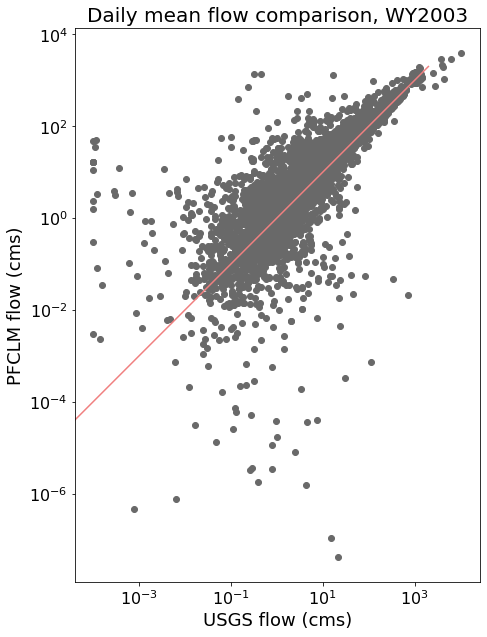

In [10]:
# Scatter plot of daily mean flow for  WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(stats_df['USGS_mean_cms'], stats_df['PF_mean_cms'], color = 'dimgrey')
ax.plot(range(2000), color = 'lightcoral')
plt.ylabel('PFCLM flow (cms)',fontsize=18)
plt.xlabel('USGS flow (cms)',fontsize=18)
plt.title('Daily mean flow comparison, WY2003',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')#########THIS IS BROKENNNNNNNNNNN
plt.savefig(f'{plot_dir}/WY2003_daily_mean_flow_comparison_scatter.png')


## Map Plots

In [11]:
from PIL import Image

# Read in CONUS2 mask and HUC2 png for map plot border and HUC2 outlines
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
mask_array = np.array(CONUS2_mask)
HUC2_outline = Image.open('/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/mapping_scripts/CONUS2_outline_with_HUC2_noSqrBorder.png')


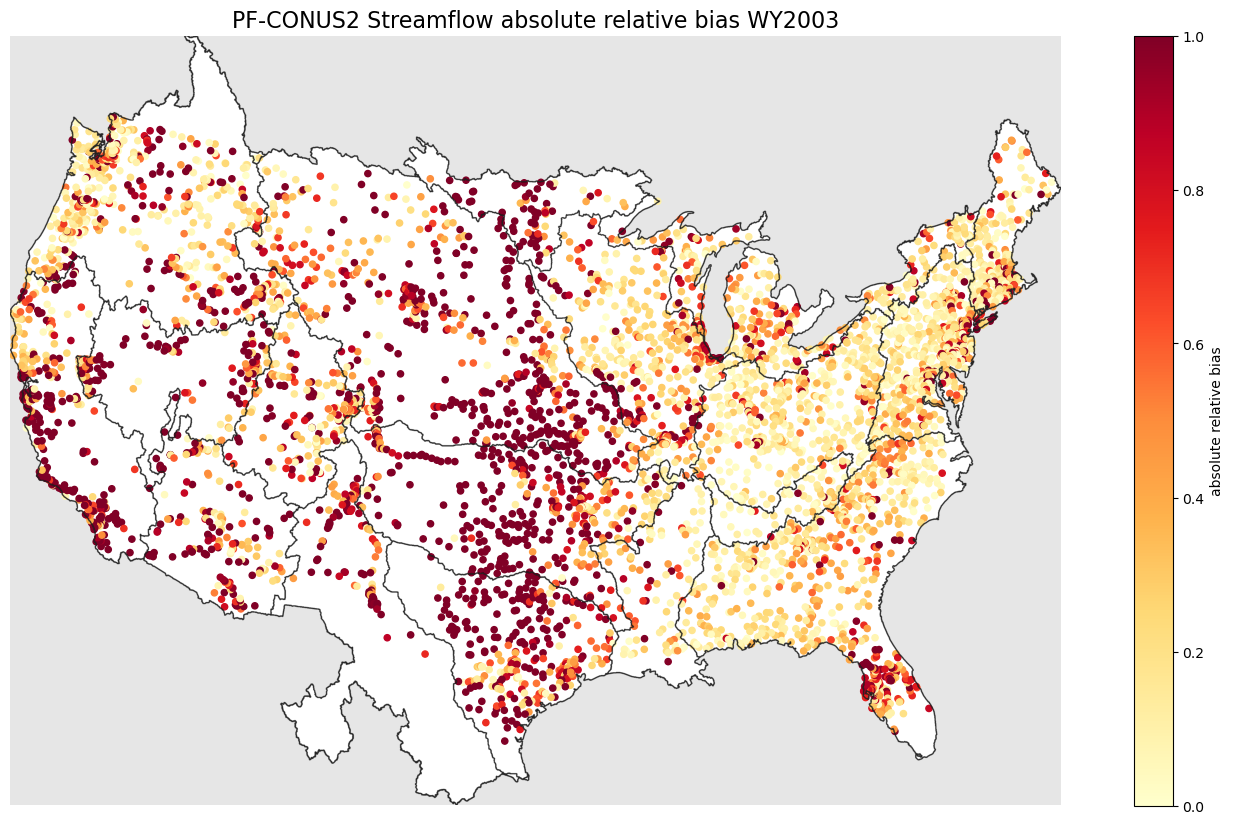

In [12]:
### Absolute Relative Bias
### Good values are closer to 0.0
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.absrelbias, cmap='YlOrRd', s=20, vmin = 0, vmax = 1, zorder=1)
plt.colorbar(points, label = 'absolute relative bias')
plt.title(f'PF-CONUS2 Streamflow absolute relative bias WY{water_year}', fontsize = 16)
plt.axis('off')
plt.savefig(f'{plot_dir}/PFCONUS2_AbsRelBias_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

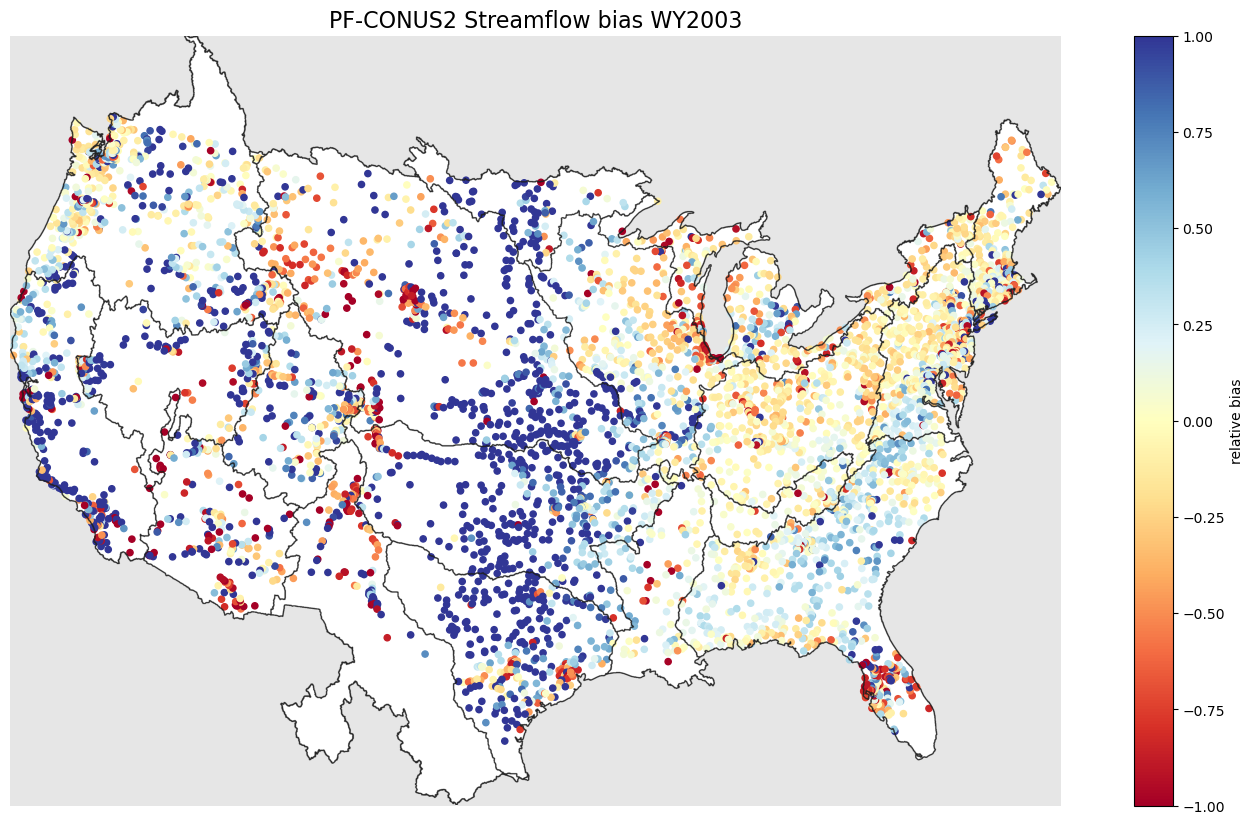

In [13]:
### Relative Bias
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.bias, cmap='RdYlBu', s=20, vmin = -1, vmax = 1, zorder=1)
plt.colorbar(points, label = 'relative bias')
plt.axis('off')
plt.title(f'PF-CONUS2 Streamflow bias WY{water_year}', fontsize = 16)
plt.savefig(f'{plot_dir}/PFCONUS2_RelBias_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

In [14]:
print(stats_df.pf_minus_obs.max())
stats_df.pf_minus_obs.min()

501896.885179908


-2376575.259631489

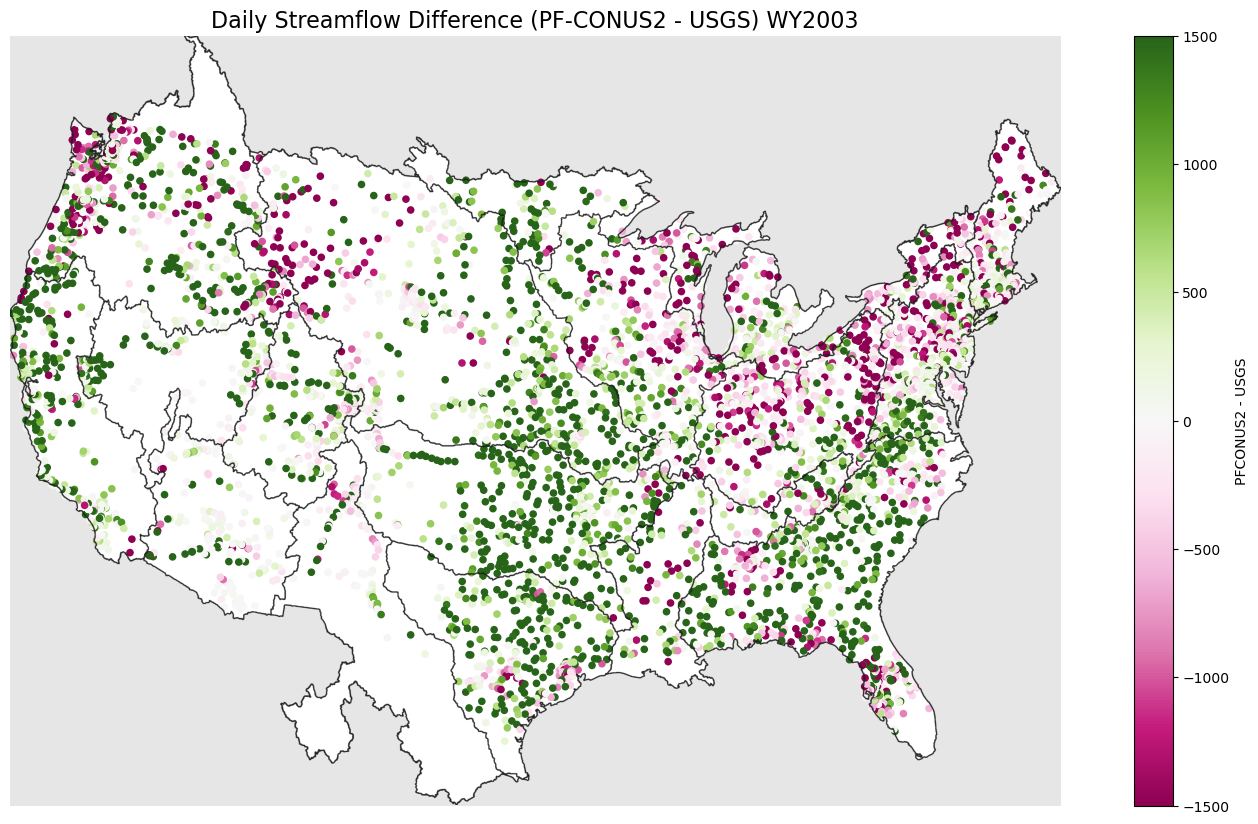

In [15]:
### PF - USGS
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.pf_minus_obs, cmap='PiYG', vmin = -1500, vmax = 1500, s=20, zorder=1)
plt.colorbar(points, label = 'PFCONUS2 - USGS') #
plt.title(f'Daily Streamflow Difference (PF-CONUS2 - USGS) WY{water_year}', fontsize = 16)
plt.axis('off')
plt.savefig(f'{plot_dir}/PFCONUS2_StreamflowDiff_PF-USGS_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

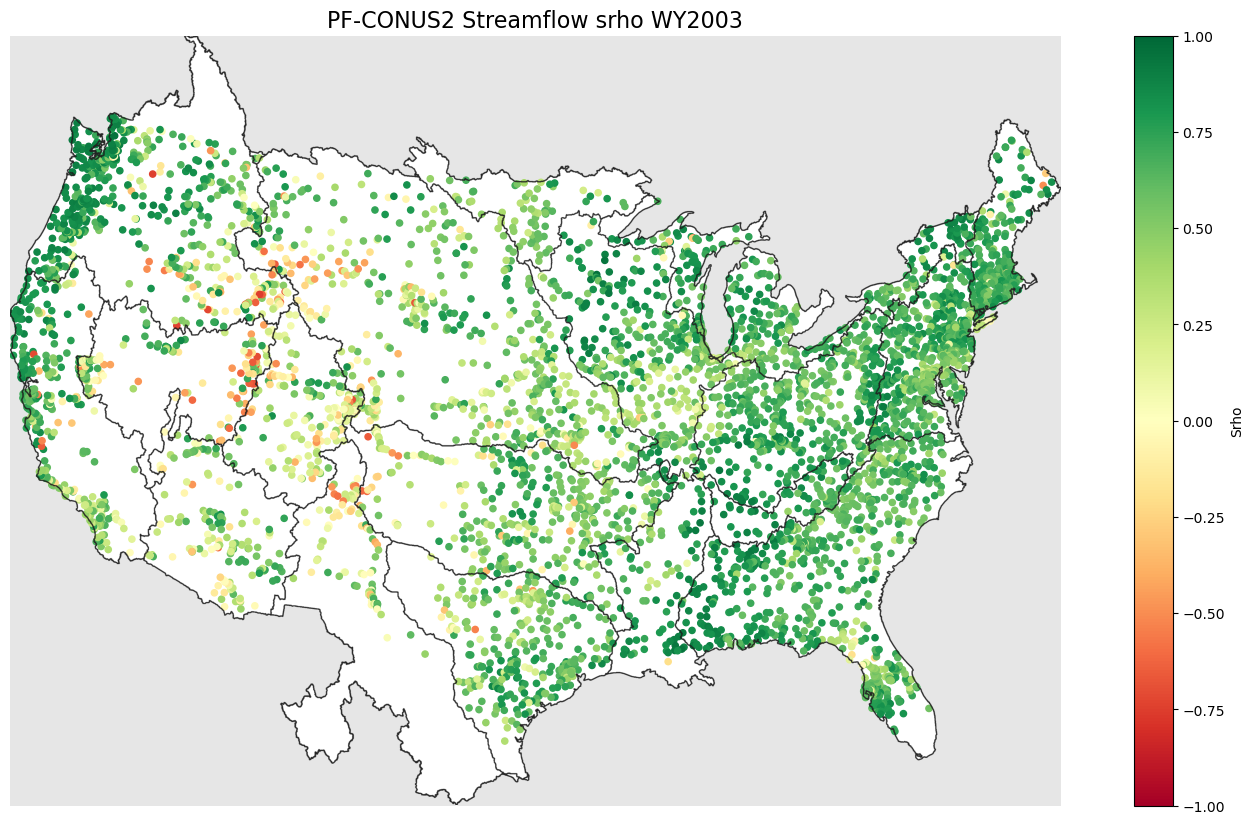

In [16]:
### Spearmans's Rho
### Good values are closer to 0.0
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.srho, s=20, vmin = -1, vmax = 1, cmap = 'RdYlGn', zorder=1)
plt.colorbar(points, label = 'Srho')
plt.axis('off')
plt.title(f'PF-CONUS2 Streamflow srho WY{water_year}', fontsize = 16)
plt.savefig(f'{plot_dir}/PFCONUS2_Srho_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

In [ ]:

# plt.figure(figsize=(5,5))
# n, bins_limits, patches = plt.hist(obsv, bins=np.logspace(np.log10(1e-6),np.log10(1e7), 80), color='r', alpha=0.5, label='USGS')
# plt.hist(simv, bins = bins_limits, color='b', alpha=0.5, label='CONUS2')
# plt.xlabel('streamflow ($\mathregular{m^3}$/h)')
# plt.ylabel('Frequency')
# plt.xscale('log')
# plt.legend()
# plt.xlim(1e-2,1e8)


#### Testing some geopandas plotting below...

In [31]:

from shapely.geometry import Point

<AxesSubplot:>

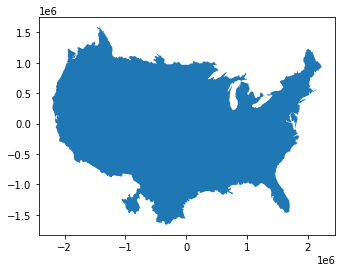

In [28]:
shp_dir = '/glade/p/univ/ucsm0009/CONUS2/domain_files/CONUS2_domain_LCC.shp'
conus2_shp = gpd.read_file(shp_dir)
conus2_shp.plot()

/glade/work/tijerina/conda-envs/parflow-npl/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


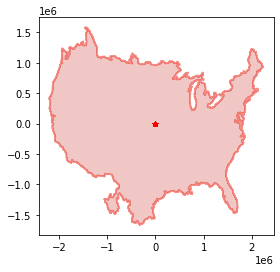

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

long = stats_df.longitude
lat = stats_df.latitude
geometry = [Point(xy) for xy in zip(long,lat)]

#ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)

conus2_shp.crs = {'init':"epsg:4326"}
geo_df.crs = {'init':"epsg:4326"}

# plot the polygon
ax = conus2_shp.plot(alpha=0.35, color='#d66058', zorder=1)
# plot the boundary only (without fill), just uncomment
ax = gpd.GeoSeries(conus2_shp['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)

# plot the marker
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*', zorder=3)

In [41]:
geo_df

,geometry
0,POINT (-69.07944 47.06972)
1,POINT (-68.58278 47.23750)
2,POINT (-68.37167 46.52306)
3,POINT (-68.15722 46.77722)
4,POINT (-67.95306 46.62806)
...,...
4956,POINT (-123.14005 42.24151)
4957,POINT (-123.40673 42.35401)
4958,POINT (-124.05814 42.57844)
4959,POINT (-123.66368 42.23178)


In [29]:
conus2_shp.crs
#inProj = Proj(init='epsg:4326')

<Projected CRS: ESRI:102004>
Name: USA_Contiguous_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich